# Fama-French 5 Factors Replication

This script replicates the Fama French 5 risk factors SMB, HML, RMW, and CMA, in addition to the excess market risk factor. The data come from CRSP for pricing related items and Compustat for fundamental data. The data are accessed through WRDS.

This script has been adapted from the Fama French 3 factors script posted on WRDS, written by Qingyi (Freda) Song Drechsler in April 2018 and updated in June 2020.<br>(https://wrds-www.wharton.upenn.edu/pages/support/applications/python-replications/fama-french-factors-python/<br>https://www.fredasongdrechsler.com/full-python-code/fama-french)

Research notes:
- only ordinary common stocks (CRSP sharecode 10 and 11) in NYSE, AMEX and NASDAQ (exchange code 1,2,3) and at least 2 years on Compustat are included in the sample (Fama and French (1993, 2015); https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/).
- all the breakpoints are computed only on NYSE stocks (from the sample).
- market cap is calculated at issue-level (permno in CRSP), and book value of equity is calculated at company level (permco in Compustat), it is needed to aggregate market cap at company level (permco in CRSP) for later book-to-market value calculation. And market cap of companies at December of year t-1 is used for portfolio formation at June of year t. Details on how to link CRSP and Compustat:<br>
https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/crspcompustat-merged-ccm/wrds-overview-crspcompustat-merged-ccm/<br>https://wrds-www.wharton.upenn.edu/pages/support/applications/linking-databases/linking-crsp-and-compustat/
- there were cases when the same firm (CRSP permco) had two or more securities (CRSP permno) on the same date. For the purpose of ME for the firm, I aggregated all ME for a given CRSP permco, date. This aggregated ME was assigned to the CRSP permno according to the following criteria largest market equity (ME), higher number of years on Compustat (count) (as recommended by WRDS (https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/) and finally random, in this order. If the ME and years on Compustat are the same there is no other unbiased criteria but random (one would select the one with either largest or smallest return). However these cases are less than 100. The ME to assign to the permco is the sum of the ME of all the permno of that permco.
- the relevant share code for Fama French factors constructions are 10 and 11 (ordinary common stocks). The permno for the same permco may have different share code (shrcd), filtering them before applying the logic o the previous point would end up in loosing market capitalization. The solution is to delete later, when each permco has only one permno, all the permno with shrcd different from 10 or 11.
- I merged CRSP and Compustat using the CRSP CCM product (as of April 2010) as recommended by WRDS (https://wrds-www.wharton.upenn.edu/pages/support/applications/risk-factors-and-industry-benchmarks/fama-french-factors/) matching Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t. Data was cleaned for unnecessary duplicates. First there were cases when different gvkeys exist for same permno-date. I solved these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P'). There were other unnecessary duplicates that were removed (I kept the oldest gvkey for each permno, finally I randomly picked one gvkey for each of of the about 30 pairs od dupliated permno which were practically identical if not for fractions of decimals differences on certain measures). Some companies on Compustat may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we selected the last annual record for a given calendar year

Variable definitions (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/variable_definitions.html)

- ME: Market Equity. Market equity (size) is price times shares outstanding. Price is from CRSP, shares outstanding are from Compustat (if available) or CRSP.
 	 	 
- BE: Equity. Book equity is constructed from Compustat data or collected from the Moody’s Industrial, Financial, and Utilities manuals. BE is the book value of stockholders’ equity, plus balance sheet deferred taxes and investment tax credit (if available), minus the book value of preferred stock. Depending on availability, we use the redemption, liquidation, or par value (in that order) to estimate the book value of preferred stock. Stockholders’ equity is the value reported by Moody’s or Compustat, if it is available. If not, we measure stockholders’ equity as the book value of common equity plus the par value of preferred stock, or the book value of assets minus total liabilities (in that order). See Davis, Fama, and French, 2000, “Characteristics, Covariances, and Average Returns: 1929-1997,” Journal of Finance, for more details.
 	 	 
- BE/ME: Book-to-Market. The book-to-market ratio used to form portfolios in June of year t is book equity for the fiscal year ending in calendar year t-1, divided by market equity at the end of December of t-1.
 	 	 
- OP: Operating Profitability. The operating profitability ratio used to form portfolios in June of year t is annual revenues minus cost of goods sold, interest expense, and selling, general, and administrative expense divided by the sum of book equity and minority interest for the last fiscal year ending in t-1.
 	 	 
- INV: Investment. The investment ratio used to form portfolios in June of year t is the change in total assets from the fiscal year ending in year t-2 to the fiscal year ending in t-1, divided by t-2 total assets.

Techincal notes:

In order to tun the script one has to connect ot the WRDS databases and have a valid WRDS account. Here are the details on how to set up a connection or run the scrip on the WRDS cloud.<br>https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-wrds-cloud/<br>https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-from-your-computer/

WRDS Python library documentation
https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

Descriptions of Fama French 5 factors (2x3) can be found on Kenneth French's website.<br>http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html <br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

References:
- Fama, Eugene F. and Kenneth R. French, 1993, Common Risk Factors in Stocks and Bonds, Journal of Financial Economics , 
33, 3-56.
- Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

Script

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import urllib
import zipfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

#set to 1 to delete intermediate datasets
save_memory=0

In [2]:
#Creation of a WRDS connection (you need to have a valid WRDS account, execute this only the first time)
# db = wrds.Connection(wrds_username='xxxxxxxxx')
# db.create_pgpass_file()
# db.close()

In [3]:
conn = wrds.Connection(wrds_username='')

Loading library list...
Done


In [4]:
# extracting fundamental information from Compustat
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk, revt, cogs, xsga, xint, mib
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1958'
                    """)
comp['datadate']=pd.to_datetime(comp['datadate']) #convert datadate to date format
comp['year']=comp['datadate'].dt.year
comp

,gvkey,datadate,at,pstkl,txditc,pstkrv,seq,pstk,revt,cogs,xsga,xint,mib,year
0,001000,1961-12-31,NaN,0.0,0.000,NaN,NaN,NaN,0.900,NaN,NaN,NaN,0.0,1961
1,001000,1962-12-31,NaN,0.0,NaN,NaN,NaN,0.0,1.600,NaN,NaN,0.010,0.0,1962
2,001000,1963-12-31,NaN,0.0,0.008,0.0,0.553,0.0,1.457,1.065,0.346,0.020,0.0,1963
3,001000,1964-12-31,1.416,0.0,0.020,0.0,0.607,0.0,2.032,1.474,0.431,0.033,0.0,1964
4,001000,1965-12-31,2.310,0.0,0.000,0.0,0.491,0.0,1.688,1.342,0.506,0.062,0.0,1965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527694,345980,2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
527695,345980,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
527696,345980,2018-12-31,1193.000,1380.0,0.000,1380.0,89.000,1376.0,1728.000,270.000,1673.000,NaN,0.0,2018
527697,345980,2019-12-31,1366.000,1619.0,0.000,1619.0,97.000,1536.0,1901.000,433.000,1602.000,NaN,0.0,2019


Data legend:
https://wrds-www.wharton.upenn.edu/data-dictionary/comp_na_annual_all/funda/

- at = Assets - Total
- pstkl = Preferred Stock - Liquidating Value
- txditc = 	Deferred Taxes and Investment Tax Credit
- pstkrv = Preferred Stock - Redemption Value
- seq = Stockholders Equity - Parent
- pstk = Preferred/Preference Stock (Capital) - Total
- revt = Revenue - Total
- cogs = Cost of Goods Sold
- xint = Interest and Related Expense - Total
- xsga = Selling, General and Administrative Expense
- mib = Noncontrolling Interest (Balance Sheet) (Formerly Minority Interest (Balance Sheet))

In [5]:
# check if index is unique
print(comp.set_index(['gvkey','year']).index.is_unique)

False


In [6]:
#select most recent datadate for each gvkey and year when there are multiple datadate (due to change of end of fiscal year)
comp=comp.sort_values(['gvkey','year','datadate'], ascending=[True,True,False]).drop_duplicates(subset=['gvkey','year'], keep='first')

# check if index is unique
print(comp.set_index(['gvkey','year']).index.is_unique)
comp

True


,gvkey,datadate,at,pstkl,txditc,pstkrv,seq,pstk,revt,cogs,xsga,xint,mib,year
0,001000,1961-12-31,NaN,0.0,0.000,NaN,NaN,NaN,0.900,NaN,NaN,NaN,0.0,1961
1,001000,1962-12-31,NaN,0.0,NaN,NaN,NaN,0.0,1.600,NaN,NaN,0.010,0.0,1962
2,001000,1963-12-31,NaN,0.0,0.008,0.0,0.553,0.0,1.457,1.065,0.346,0.020,0.0,1963
3,001000,1964-12-31,1.416,0.0,0.020,0.0,0.607,0.0,2.032,1.474,0.431,0.033,0.0,1964
4,001000,1965-12-31,2.310,0.0,0.000,0.0,0.491,0.0,1.688,1.342,0.506,0.062,0.0,1965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527695,345980,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
527486,345980,2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
527696,345980,2018-12-31,1193.000,1380.0,0.000,1380.0,89.000,1376.0,1728.000,270.000,1673.000,NaN,0.0,2018
527697,345980,2019-12-31,1366.000,1619.0,0.000,1619.0,97.000,1536.0,1901.000,433.000,1602.000,NaN,0.0,2019


In [7]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv']) # save pstkrv in ps if pstkrv is not null, else pstkl
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps']) # save pstk in ps if ps is not null, else ps
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps']) # save 0 in ps if ps is null, else leave ps
comp

,gvkey,datadate,at,pstkl,txditc,pstkrv,seq,pstk,revt,cogs,xsga,xint,mib,year,ps
0,001000,1961-12-31,NaN,0.0,0.000,NaN,NaN,NaN,0.900,NaN,NaN,NaN,0.0,1961,0.0
1,001000,1962-12-31,NaN,0.0,NaN,NaN,NaN,0.0,1.600,NaN,NaN,0.010,0.0,1962,0.0
2,001000,1963-12-31,NaN,0.0,0.008,0.0,0.553,0.0,1.457,1.065,0.346,0.020,0.0,1963,0.0
3,001000,1964-12-31,1.416,0.0,0.020,0.0,0.607,0.0,2.032,1.474,0.431,0.033,0.0,1964,0.0
4,001000,1965-12-31,2.310,0.0,0.000,0.0,0.491,0.0,1.688,1.342,0.506,0.062,0.0,1965,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527695,345980,2016-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.0
527486,345980,2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,0.0
527696,345980,2018-12-31,1193.000,1380.0,0.000,1380.0,89.000,1376.0,1728.000,270.000,1673.000,NaN,0.0,2018,1380.0
527697,345980,2019-12-31,1366.000,1619.0,0.000,1619.0,97.000,1536.0,1901.000,433.000,1602.000,NaN,0.0,2019,1619.0


In [8]:
# create book equity as (Stockholders Equity - Parent) + (Deferred Taxes and Investment Tax Credit) - preferrerd stock
comp['txditc']=comp['txditc'].fillna(0)
comp['be']=comp['seq']+comp['txditc']-comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan) # replace negative book equity with nan
comp

,gvkey,datadate,at,pstkl,txditc,pstkrv,seq,pstk,revt,cogs,xsga,xint,mib,year,ps,be
0,001000,1961-12-31,NaN,0.0,0.000,NaN,NaN,NaN,0.900,NaN,NaN,NaN,0.0,1961,0.0,NaN
1,001000,1962-12-31,NaN,0.0,0.000,NaN,NaN,0.0,1.600,NaN,NaN,0.010,0.0,1962,0.0,NaN
2,001000,1963-12-31,NaN,0.0,0.008,0.0,0.553,0.0,1.457,1.065,0.346,0.020,0.0,1963,0.0,0.561
3,001000,1964-12-31,1.416,0.0,0.020,0.0,0.607,0.0,2.032,1.474,0.431,0.033,0.0,1964,0.0,0.627
4,001000,1965-12-31,2.310,0.0,0.000,0.0,0.491,0.0,1.688,1.342,0.506,0.062,0.0,1965,0.0,0.491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527695,345980,2016-12-31,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.0,NaN
527486,345980,2017-12-31,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,0.0,NaN
527696,345980,2018-12-31,1193.000,1380.0,0.000,1380.0,89.000,1376.0,1728.000,270.000,1673.000,NaN,0.0,2018,1380.0,NaN
527697,345980,2019-12-31,1366.000,1619.0,0.000,1619.0,97.000,1536.0,1901.000,433.000,1602.000,NaN,0.0,2019,1619.0,NaN


In [9]:
# number of years in Compustat for each gvkey
comp=comp.sort_values(['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

In [10]:
# keep only the companies' observations of companies present on Compustat for at least 2 years
comp=comp[comp['count']>=1]
comp

,gvkey,datadate,at,pstkl,txditc,pstkrv,seq,pstk,revt,cogs,xsga,xint,mib,year,ps,be,count
1,001000,1962-12-31,NaN,0.0,0.000,NaN,NaN,0.0,1.600,NaN,NaN,0.010,0.0,1962,0.0,NaN,1
2,001000,1963-12-31,NaN,0.0,0.008,0.0,0.553,0.0,1.457,1.065,0.346,0.020,0.0,1963,0.0,0.561,2
3,001000,1964-12-31,1.416,0.0,0.020,0.0,0.607,0.0,2.032,1.474,0.431,0.033,0.0,1964,0.0,0.627,3
4,001000,1965-12-31,2.310,0.0,0.000,0.0,0.491,0.0,1.688,1.342,0.506,0.062,0.0,1965,0.0,0.491,4
5,001000,1966-12-31,2.430,0.0,0.000,0.0,0.834,0.0,4.032,2.828,0.679,0.095,0.0,1966,0.0,0.834,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527695,345980,2016-12-31,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,0.0,NaN,1
527486,345980,2017-12-31,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,0.0,NaN,2
527696,345980,2018-12-31,1193.000,1380.0,0.000,1380.0,89.000,1376.0,1728.000,270.000,1673.000,NaN,0.0,2018,1380.0,NaN,3
527697,345980,2019-12-31,1366.000,1619.0,0.000,1619.0,97.000,1536.0,1901.000,433.000,1602.000,NaN,0.0,2019,1619.0,NaN,4


In [11]:
# compute Fama French investment ratio
# computed as the change in total asset between t-2 and t-1 divided by at in t-1
# to be used to form portfolio in June of year t
comp['inv']=comp.groupby('gvkey')['at'].pct_change()

In [12]:
# compute Fama French operating profitability
# the value use to form portfolios in June of year t is computed as 
# annual revenues minus cost of goods sold, interest expense, and selling, general, and administrative expense
# divided by the sum of book equity and minority interest for the last fiscal year ending in t-1.
comp['op']=(comp['revt'] - comp['cogs'].fillna(0) - comp['xint'].fillna(0) - comp['xsga'].fillna(0))/(comp['be'] + comp['mib'].fillna(0))

In [13]:
comp=comp[['gvkey','datadate','year','be','count','inv','op','revt','mib','cogs','xint','xsga']]
comp

,gvkey,datadate,year,be,count,inv,op,revt,mib,cogs,xint,xsga
1,001000,1962-12-31,1962,NaN,1,NaN,NaN,1.600,0.0,NaN,0.010,NaN
2,001000,1963-12-31,1963,0.561,2,NaN,0.046346,1.457,0.0,1.065,0.020,0.346
3,001000,1964-12-31,1964,0.627,3,NaN,0.149920,2.032,0.0,1.474,0.033,0.431
4,001000,1965-12-31,1965,0.491,4,0.631356,-0.452138,1.688,0.0,1.342,0.062,0.506
5,001000,1966-12-31,1966,0.834,5,0.051948,0.515588,4.032,0.0,2.828,0.095,0.679
...,...,...,...,...,...,...,...,...,...,...,...,...
527695,345980,2016-12-31,2016,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527486,345980,2017-12-31,2017,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527696,345980,2018-12-31,2018,NaN,3,NaN,NaN,1728.000,0.0,270.000,NaN,1673.000
527697,345980,2019-12-31,2019,NaN,4,0.145013,NaN,1901.000,0.0,433.000,NaN,1602.000


In [14]:
# extracting price and securities infromations from CRSP
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1958' and '12/31/2020'
                      and b.exchcd between 1 and 3
                      """)
# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)
crsp_m['date']=pd.to_datetime(crsp_m['date'])
crsp_m['jdate']=crsp_m['date']+MonthEnd(0) # create end of the month dates
crsp_m

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate
0,10001,7953,1987-11-30,11,3,-0.029412,-0.029412,992.0,6.1875,1987-11-30
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.5000,1991-03-31
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.8750,1991-04-30
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.8750,1991-05-31
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.5000,1991-06-30
...,...,...,...,...,...,...,...,...,...,...
4059960,93399,53425,2016-06-30,11,3,0.030495,0.008254,24141.0,2.0400,2016-06-30
4059961,92891,53122,2009-07-31,14,1,0.020861,0.015894,11500.0,15.3400,2009-07-31
4059962,92891,53122,2009-08-31,14,1,0.022490,0.017601,11500.0,15.6100,2009-08-31
4059963,92891,53122,2009-09-30,14,1,0.009289,0.004484,11500.0,15.6800,2009-09-30


Data legend:

Table: CRSP Monthly Stock Event - Name History (msenames)
https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_a_stock/msenames/

- shrc = Share Code
- exchcd = Exchange Code
- permno = PERMNO
- namedt = Names Date
- nameendt = Names Ending Date

Table: Monthly Stock - Securities (msf)
https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_m_stock/msf/

- permno = PERMNO
- permco = PERMCO
- date = Date of Observation
- ret = Returns
- retx = Returns without Dividends
- shrout = Shares Outstanding
- prc = Price or Bid/Ask Average

CRSP Monthly Stock Event - Delisting (msedelist)
https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_m_stock/msedelist/
- permno = PERMNO
- dlstdt = Delisting Date
- dlret = Delisting Return

In [15]:
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)
dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0) # create end of the month dates
dlret

,permno,dlret,dlstdt,jdate
0,10000,0.000000,1987-06-11,1987-06-30
1,10001,0.011583,2017-08-03,2017-08-31
2,10002,0.046007,2013-02-15,2013-02-28
3,10003,0.013730,1995-12-15,1995-12-31
4,10005,0.125000,1991-07-11,1991-07-31
...,...,...,...,...
34396,93432,-0.827922,2011-05-31,2011-05-31
34397,93433,-0.127273,2016-12-22,2016-12-31
34398,93434,NaN,2020-12-31,2020-12-31
34399,93435,-0.778409,2012-05-18,2012-05-31


In [16]:
# calculate delisting return as the product of gross monthly Returns and gross Delisting Return, return minus 1
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
if save_memory:
    del crsp_m

crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,dlret,dlstdt,retadj
0,10001,7953,1987-11-30,11,3,-0.029412,-0.029412,992.0,6.1875,1987-11-30,0.0,NaT,-0.029412
1,10001,7953,1991-03-28,11,3,-0.011538,-0.025641,1054.0,9.5000,1991-03-31,0.0,NaT,-0.011538
2,10001,7953,1991-04-30,11,3,0.039474,0.039474,1054.0,-9.8750,1991-04-30,0.0,NaT,0.039474
3,10001,7953,1991-05-31,11,3,0.000000,0.000000,1054.0,-9.8750,1991-05-31,0.0,NaT,0.000000
4,10001,7953,1991-06-28,11,3,0.078481,0.063291,1073.0,10.5000,1991-06-30,0.0,NaT,0.078481
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4059960,93399,53425,2016-06-30,11,3,0.030495,0.008254,24141.0,2.0400,2016-06-30,0.0,NaT,0.030495
4059961,92891,53122,2009-07-31,14,1,0.020861,0.015894,11500.0,15.3400,2009-07-31,0.0,NaT,0.020861
4059962,92891,53122,2009-08-31,14,1,0.022490,0.017601,11500.0,15.6100,2009-08-31,0.0,NaT,0.022490
4059963,92891,53122,2009-09-30,14,1,0.009289,0.004484,11500.0,15.6800,2009-09-30,0.0,NaT,0.009289


In [17]:
# calculate market equity as the product of Price and Shares Outstanding 
crsp['me']=crsp['prc'].abs()*crsp['shrout'] # when Price is not available it is bid/ask average
crsp=crsp.drop(['dlret','dlstdt'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,me
586339,17670,74,1958-01-31,10,1,0.082469,0.066667,434.0,27.000000,1958-01-31,0.082469,1.171800e+04
635530,18702,267,1958-01-31,10,1,0.189024,0.189024,735.0,24.375000,1958-01-31,0.189024,1.791562e+04
708398,20714,584,1958-01-31,10,1,0.052174,0.052174,1688.0,-15.125000,1958-01-31,0.052174,2.553100e+04
159152,11287,921,1958-01-31,10,1,0.247191,0.247191,1760.0,13.875000,1958-01-31,0.247191,2.442000e+04
721232,21151,994,1958-01-31,10,1,0.254902,0.254902,1059.0,8.000000,1958-01-31,0.254902,8.472000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...
693532,20331,57663,2020-12-31,11,3,0.000000,NaN,7832.0,7.510000,2020-12-31,0.000000,5.881832e+04
693533,20332,57665,2020-12-31,11,3,0.000000,NaN,17666.0,5.910000,2020-12-31,0.000000,1.044061e+05
693534,20333,57666,2020-12-31,11,3,0.000000,NaN,478122.0,18.240000,2020-12-31,0.000000,8.720945e+06
693535,20334,57667,2020-12-31,12,3,0.000000,NaN,25000.0,37.529999,2020-12-31,0.000000,9.382500e+05


Market cap is calculated at issue-level (permno in CRSP), and book value of equity is calculated at company level (permco in Compustat), it is needed to aggregate market cap at company level (permco in CRSP) for later book-to-market value calculation. And market cap of companies at December of year t-1 is used for portfolio formation at June of year t.

When there are multiple permno for each permco, the criteria to select the permno are largest market equity (me), higher number of years on Compustat (count) and random, in this order. If the me and years on Compustat are the same there is no other unbiased criteria but random (one would select the one with either largest or smallest return). However these cases are less than 100. The me to assign to the permco is the sum of the me of all the permno of that permco.

In [18]:
# compute the toal me across permno for each permco and jdate
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
crsp_summe

,jdate,permco,me
0,1958-01-31,74,1.171800e+04
1,1958-01-31,267,1.791562e+04
2,1958-01-31,584,2.553100e+04
3,1958-01-31,921,2.442000e+04
4,1958-01-31,994,8.472000e+03
...,...,...,...
3972525,2020-12-31,57663,5.881832e+04
3972526,2020-12-31,57665,1.044061e+05
3972527,2020-12-31,57666,8.720945e+06
3972528,2020-12-31,57667,9.382500e+05


In [19]:
# permno with largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index() #this max can be the same for multiple permno for each permco
crsp_maxme

,jdate,permco,me
0,1958-01-31,74,1.171800e+04
1,1958-01-31,267,1.791562e+04
2,1958-01-31,584,2.553100e+04
3,1958-01-31,921,2.442000e+04
4,1958-01-31,994,8.472000e+03
...,...,...,...
3972525,2020-12-31,57663,5.881832e+04
3972526,2020-12-31,57665,1.044061e+05
3972527,2020-12-31,57666,8.720945e+06
3972528,2020-12-31,57667,9.382500e+05


In [20]:
# create age in months for each permno
crsp=crsp.sort_values(by=['permno','permno','jdate'])
crsp['count']=crsp.groupby(['permco','permno']).cumcount()
crsp

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,me,count
42,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375000,1986-01-31,0.000000,1.610000e+04,0
43,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,-3.250000,1986-02-28,-0.257143,1.196000e+04,1
44,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,-4.437500,1986-03-31,0.365385,1.633000e+04,2
45,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,-4.000000,1986-04-30,-0.098592,1.517200e+04,3
46,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,-3.109375,1986-05-31,-0.222656,1.179386e+04,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4058662,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,4.643391e+08,122
4058663,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,4.067015e+08,123
4058664,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,3.678235e+08,124
4058665,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,5.380286e+08,125


In [21]:
# for each permco and jdate, keep the permno with the largest me, if the same the highest age in months and eventually random pick
crsp1=crsp.sort_values(['permco','jdate','me','count']).drop_duplicates(subset=['permco','jdate'], keep='first')
crsp1

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,me,count
418620,14403,2,1972-12-29,30,3,0.000000,NaN,21952.0,-23.000000,1972-12-31,0.000000,5.048960e+05,0
418621,14403,2,1973-01-31,30,3,0.179348,0.179348,21952.0,-27.125000,1973-01-31,0.179348,5.954480e+05,1
418622,14403,2,1973-02-28,30,3,0.157272,0.129032,21952.0,-30.625000,1973-02-28,0.157272,6.722800e+05,2
418623,14403,2,1973-03-30,30,3,0.146939,0.146939,21952.0,-35.125000,1973-03-31,0.146939,7.710640e+05,3
418624,14403,2,1973-04-30,30,3,0.039146,0.039146,21952.0,-36.500000,1973-04-30,0.039146,8.012480e+05,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
693532,20331,57663,2020-12-31,11,3,0.000000,NaN,7832.0,7.510000,2020-12-31,0.000000,5.881832e+04,0
693533,20332,57665,2020-12-31,11,3,0.000000,NaN,17666.0,5.910000,2020-12-31,0.000000,1.044061e+05,0
693534,20333,57666,2020-12-31,11,3,0.000000,NaN,478122.0,18.240000,2020-12-31,0.000000,8.720945e+06,0
693535,20334,57667,2020-12-31,12,3,0.000000,NaN,25000.0,37.529999,2020-12-31,0.000000,9.382500e+05,0


In [22]:
# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info (overwrite the me of the largest permno with the me of the whole permco)
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco']).sort_values(by=['permno','jdate'])
if save_memory:
    del crsp1
    del crsp_summe
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,count,me
1067105,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375000,1986-01-31,0.000000,0,1.610000e+04
1067106,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,-3.250000,1986-02-28,-0.257143,1,1.196000e+04
1067107,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,-4.437500,1986-03-31,0.365385,2,1.633000e+04
1067108,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,-4.000000,1986-04-30,-0.098592,3,1.517200e+04
1067109,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,-3.109375,1986-05-31,-0.222656,4,1.179386e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803853,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,122,4.643391e+08
3803854,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,123,4.067015e+08
3803855,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,124,3.678235e+08
3803856,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,125,5.380286e+08


In [23]:
# keep only me>0
crsp2=crsp2[crsp2['me']>0]
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,count,me
1067105,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375000,1986-01-31,0.000000,0,1.610000e+04
1067106,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,-3.250000,1986-02-28,-0.257143,1,1.196000e+04
1067107,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,-4.437500,1986-03-31,0.365385,2,1.633000e+04
1067108,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,-4.000000,1986-04-30,-0.098592,3,1.517200e+04
1067109,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,-3.109375,1986-05-31,-0.222656,4,1.179386e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803853,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,122,4.643391e+08
3803854,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,123,4.067015e+08
3803855,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,124,3.678235e+08
3803856,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,125,5.380286e+08


In [24]:
# now that the main permno for each permco has been identified, it is possible to drop those permno whose shrcd is different from 10 or 11
crsp2=crsp2[crsp2['shrcd'].isin([10,11])] 
crsp2

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,count,me
1067105,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375000,1986-01-31,0.000000,0,1.610000e+04
1067106,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,-3.250000,1986-02-28,-0.257143,1,1.196000e+04
1067107,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,-4.437500,1986-03-31,0.365385,2,1.633000e+04
1067108,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,-4.000000,1986-04-30,-0.098592,3,1.517200e+04
1067109,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,-3.109375,1986-05-31,-0.222656,4,1.179386e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803853,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,122,4.643391e+08
3803854,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,123,4.067015e+08
3803855,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,124,3.678235e+08
3803856,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,125,5.380286e+08


In [25]:
# keep December market cap
crsp2.loc[:,'year']=crsp2.loc[:,'jdate'].dt.year
crsp2.loc[:,'month']=crsp2.loc[:,'jdate'].dt.month
decme=crsp2.loc[crsp2.loc[:,'month']==12,['permno','date','jdate','me','year']]
decme.rename(columns={'me':'dec_me'}, inplace=True)
decme

C:\Users\Andrea\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Andrea\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,permno,date,jdate,dec_me,year
1067116,10000,1986-12-31,1986-12-31,1.981547e+03,1986
1067133,10001,1986-12-31,1986-12-31,6.937000e+03,1986
1067145,10001,1987-12-31,1987-12-31,5.828000e+03,1987
1067157,10001,1988-12-30,1988-12-31,6.362250e+03,1988
1067169,10001,1989-12-29,1989-12-31,1.034775e+04,1989
...,...,...,...,...,...
3803809,93436,2016-12-30,2016-12-31,3.452397e+07,2016
3803821,93436,2017-12-29,2017-12-31,5.255495e+07,2017
3803833,93436,2018-12-31,2018-12-31,5.744194e+07,2018
3803845,93436,2019-12-31,2019-12-31,7.574366e+07,2019


In [26]:
# create a 6 months lag me
crsp2.loc[:,'ffdate']=crsp2.loc[:,'jdate']+MonthEnd(-6)
crsp2.loc[:,'ffyear']=crsp2.loc[:,'ffdate'].dt.year
crsp2.loc[:,'ffmonth']=crsp2.loc[:,'ffdate'].dt.month
crsp2.loc[:,'1+retx']=1+crsp2.loc[:,'retx']
crsp2=crsp2.sort_values(by=['permno','date'])

# cumret by stock
crsp2.loc[:,'cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2.loc[:,'lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2.loc[:,'lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first ever month of permno is January, then use me/(1+retx) to replace the missing value
crsp2.loc[:,'count']=crsp2.groupby(['permno']).cumcount()
crsp2.loc[:,'lme']=np.where(crsp2.loc[:,'count']==0, crsp2.loc[:,'me']/crsp2.loc[:,'1+retx'], crsp2.loc[:,'lme'])
crsp2

C:\Users\Andrea\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Andrea\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,count,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme
1067105,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375000,1986-01-31,0.000000,0,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN
1067106,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,-3.250000,1986-02-28,-0.257143,1,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04
1067107,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,-4.437500,1986-03-31,0.365385,2,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04
1067108,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,-4.000000,1986-04-30,-0.098592,3,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04
1067109,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,-3.109375,1986-05-31,-0.222656,4,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3803853,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,122,4.643391e+08,2020,8,2020-02-29,2020,2,1.741452,2.307443,1.325011,2.666393e+08
3803854,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,123,4.067015e+08,2020,9,2020-03-31,2020,3,0.860913,1.986507,2.307443,4.643391e+08
3803855,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,124,3.678235e+08,2020,10,2020-04-30,2020,4,0.904501,1.796798,1.986507,4.067015e+08
3803856,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,125,5.380286e+08,2020,11,2020-05-31,2020,5,1.462736,2.628240,1.796798,3.678235e+08


In [27]:
# find the baseline me (me in July of each year). ffmonth is july, lme is the lag 1 of me, therefore june
mebase=crsp2.loc[crsp2['ffmonth']==1,['permno','ffyear','lme']].rename(columns={'lme':'mebase'})
mebase

,permno,ffyear,mebase
1067111,10000,1986,1.173459e+04
1067128,10001,1986,6.033125e+03
1067140,10001,1987,5.822125e+03
1067152,10001,1988,6.200000e+03
1067164,10001,1989,7.007000e+03
...,...,...,...
3803804,93436,2016,3.142062e+07
3803816,93436,2017,6.033933e+07
3803828,93436,2018,5.847846e+07
3803840,93436,2019,4.002571e+07


In [28]:
### add to crsp dataset, the evolution of the base me (the one of the relevante previous December) using the gross returns
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
if save_memory:
    del crsp2
    del mebase

# computation of the evolution of me over the next 12 months based on the gross returns. ffmonth=1 is july, lme is me in june
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])
crsp3

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,count,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,mebase,wt
0,10000,7952,1986-01-31,10,3,0.000000,NaN,3680.0,-4.375000,1986-01-31,0.000000,0,1.610000e+04,1986,1,1985-07-31,1985,7,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,-3.250000,1986-02-28,-0.257143,1,1.196000e+04,1986,2,1985-08-31,1985,8,0.742857,0.742857,NaN,1.610000e+04,NaN,NaN
2,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,-4.437500,1986-03-31,0.365385,2,1.633000e+04,1986,3,1985-09-30,1985,9,1.365385,1.014286,0.742857,1.196000e+04,NaN,NaN
3,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,-4.000000,1986-04-30,-0.098592,3,1.517200e+04,1986,4,1985-10-31,1985,10,0.901408,0.914286,1.014286,1.633000e+04,NaN,NaN
4,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,-3.109375,1986-05-31,-0.222656,4,1.179386e+04,1986,5,1985-11-30,1985,11,0.777344,0.710714,0.914286,1.517200e+04,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243552,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,122,4.643391e+08,2020,8,2020-02-29,2020,2,1.741452,2.307443,1.325011,2.666393e+08,2.008447e+08,2.661214e+08
3243553,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,123,4.067015e+08,2020,9,2020-03-31,2020,3,0.860913,1.986507,2.307443,4.643391e+08,2.008447e+08,4.634376e+08
3243554,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,124,3.678235e+08,2020,10,2020-04-30,2020,4,0.904501,1.796798,1.986507,4.067015e+08,2.008447e+08,3.989793e+08
3243555,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,125,5.380286e+08,2020,11,2020-05-31,2020,5,1.462736,2.628240,1.796798,3.678235e+08,2.008447e+08,3.608772e+08


In [29]:
# check if index is unique
print(crsp3.set_index(['permno','jdate']).index.is_unique)

#delete rows where wt is not present or equal to 0, since they cannot be used in the portfolio construction
crsp3=crsp3[crsp3['wt']>0]
crsp3

True


,permno,permco,date,shrcd,exchcd,ret,retx,shrout,prc,jdate,retadj,count,me,year,month,ffdate,ffyear,ffmonth,1+retx,cumretx,lcumretx,lme,mebase,wt
6,10000,7952,1986-07-31,10,3,-0.080808,-0.080808,3793.0,-2.843750,1986-07-31,-0.080808,6,1.078634e+04,1986,7,1986-01-31,1986,1,0.919192,0.919192,0.707143,1.173459e+04,1.173459e+04,1.173459e+04
7,10000,7952,1986-08-29,10,3,-0.615385,-0.615385,3793.0,-1.093750,1986-08-31,-0.615385,7,4.148594e+03,1986,8,1986-02-28,1986,2,0.384615,0.353535,0.919192,1.078634e+04,1.173459e+04,1.078634e+04
8,10000,7952,1986-09-30,10,3,-0.057143,-0.057143,3793.0,-1.031250,1986-09-30,-0.057143,8,3.911531e+03,1986,9,1986-03-31,1986,3,0.942857,0.333333,0.353535,4.148594e+03,1.173459e+04,4.148594e+03
9,10000,7952,1986-10-31,10,3,-0.242424,-0.242424,3843.0,-0.781250,1986-10-31,-0.242424,9,3.002344e+03,1986,10,1986-04-30,1986,4,0.757576,0.252525,0.333333,3.911531e+03,1.173459e+04,3.911531e+03
10,10000,7952,1986-11-28,10,3,0.060000,0.060000,3843.0,-0.828125,1986-11-30,0.060000,10,3.182484e+03,1986,11,1986-05-31,1986,5,1.060000,0.267677,0.252525,3.002344e+03,1.173459e+04,2.963281e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243552,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,498.320007,2020-08-31,0.741452,122,4.643391e+08,2020,8,2020-02-29,2020,2,1.741452,2.307443,1.325011,2.666393e+08,2.008447e+08,2.661214e+08
3243553,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,429.010010,2020-09-30,-0.139087,123,4.067015e+08,2020,9,2020-03-31,2020,3,0.860913,1.986507,2.307443,4.643391e+08,2.008447e+08,4.634376e+08
3243554,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,388.040009,2020-10-31,-0.095499,124,3.678235e+08,2020,10,2020-04-30,2020,4,0.904501,1.796798,1.986507,4.067015e+08,2.008447e+08,3.989793e+08
3243555,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,567.599976,2020-11-30,0.462736,125,5.380286e+08,2020,11,2020-05-31,2020,5,1.462736,2.628240,1.796798,3.678235e+08,2.008447e+08,3.608772e+08


In [30]:
### create table with only observation of June year t and add to them year t-1 end of December me
# create for each year the relevante previous year end of December me
decme['year']=decme['year']+1
decme=decme.loc[:,['permno','year','dec_me']]

# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

# add to June of year t the year t-1 end of December me
crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
if save_memory:
    del decme
    del crsp3_jun

# check if index is unique
print(crsp_jun.set_index(['permno','jdate']).index.is_unique)
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','shrout','prc','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun

True


,permno,date,jdate,shrcd,exchcd,shrout,prc,retadj,me,wt,cumretx,mebase,lme,dec_me
0,10001,1987-06-30,1987-06-30,11,3,991.0,5.875000,0.051429,5.822125e+03,5.602187e+03,0.959184,6.033125e+03,5.636312e+03,6.937000e+03
1,10001,1988-06-30,1988-06-30,11,3,992.0,6.250000,-0.012039,6.200000e+03,6.379563e+03,1.063830,5.822125e+03,6.386000e+03,5.828000e+03
2,10001,1989-06-30,1989-06-30,11,3,1001.0,7.000000,0.017143,7.007000e+03,6.944000e+03,1.120000,6.200000e+03,6.986000e+03,6.362250e+03
3,10001,1990-06-29,1990-06-30,11,3,1031.0,9.750000,0.014103,1.005225e+04,9.759750e+03,1.392857,7.007000e+03,1.001325e+04,1.034775e+04
4,10001,1991-06-28,1991-06-30,11,3,1073.0,10.500000,0.078481,1.126650e+04,1.018112e+04,1.076923,1.005225e+04,1.040825e+04,1.001300e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243837,93436,2016-06-30,2016-06-30,11,3,148015.0,212.279999,-0.049053,3.142062e+07,2.837276e+07,0.791322,3.409612e+07,3.293602e+07,3.154331e+07
243838,93436,2017-06-30,2017-06-30,11,3,166863.0,361.609985,0.060409,6.033933e+07,5.047460e+07,1.703458,3.142062e+07,5.601430e+07,3.452397e+07
243839,93436,2018-06-29,2018-06-30,11,3,170516.0,342.950012,0.204474,5.847846e+07,4.751090e+07,0.948398,6.033933e+07,4.834545e+07,5.255495e+07
243840,93436,2019-06-28,2019-06-30,11,3,179118.0,223.460007,0.206848,4.002571e+07,3.157274e+07,0.651582,5.847846e+07,3.282331e+07,5.744194e+07


In [31]:
# extracting CCM linking table to join CRSP to Compustat
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)
ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))
ccm

,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30 00:00:00.000000
1,001001,10015.0,LU,P,1983-09-20,1986-07-31 00:00:00.000000
2,001002,10023.0,LC,C,1972-12-14,1973-06-05 00:00:00.000000
3,001003,10031.0,LU,C,1983-12-07,1989-08-16 00:00:00.000000
4,001004,54594.0,LU,P,1972-04-24,2021-07-09 09:27:09.982604
...,...,...,...,...,...,...
34315,345189,14299.0,LC,C,2020-07-31,2020-11-30 00:00:00.000000
34316,345189,14299.0,LC,P,2020-12-01,2021-07-09 09:27:09.982604
34317,345556,16069.0,LC,P,2020-11-23,2021-07-09 09:27:09.982604
34318,345920,20194.0,LC,P,2020-12-10,2021-07-09 09:27:09.982604


In [32]:
### merge compustat with ccm linking tables
ccm1=pd.merge(comp[['gvkey','datadate','be', 'count','inv','op','revt','mib','cogs','xint','xsga']],ccm,how='left',on=['gvkey'])
if save_memory:
    del ccm

ccm1['yearend']=ccm1['datadate']+YearEnd(0) # end of year t
ccm1['jdate']=ccm1['yearend']+MonthEnd(6) # year t+1 June
ccm1

# filter the links not updated (links started after or finished earlier than June year t+1)
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
if save_memory:
    del ccm1
ccm2=ccm2[['gvkey','permno','linkprim','datadate','yearend', 'jdate','be', 'count','inv','op','revt','mib','cogs','xint','xsga']]
ccm2

,gvkey,permno,linkprim,datadate,yearend,jdate,be,count,inv,op,revt,mib,cogs,xint,xsga
8,001000,25881.0,P,1970-12-31,1970-12-31,1971-06-30,10.544,9,0.165018,0.430197,45.335,0.0,30.529,0.850,9.420
9,001000,25881.0,P,1971-12-31,1971-12-31,1972-06-30,8.382,10,-0.123169,0.166428,47.033,0.0,33.973,1.117,10.548
10,001000,25881.0,P,1972-12-31,1972-12-31,1973-06-30,7.309,11,-0.321275,0.454919,34.362,0.0,22.702,0.784,7.551
11,001000,25881.0,P,1973-12-31,1973-12-31,1974-06-30,8.798,12,0.093635,0.432939,37.750,0.0,24.704,0.705,8.532
12,001000,25881.0,P,1974-12-31,1974-12-31,1975-06-30,8.279,13,0.177622,0.483513,50.325,0.0,36.646,0.817,8.859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578950,335466,14756.0,C,2018-12-31,2018-12-31,2019-06-30,54.064,3,NaN,-0.361091,20.654,0.0,27.388,8.031,4.757
578953,335466,14756.0,P,2019-12-31,2019-12-31,2020-06-30,52.128,4,0.056706,-0.161430,41.813,0.0,35.361,9.126,5.741
578954,339965,19654.0,P,2020-01-31,2020-12-31,2021-06-30,NaN,1,NaN,NaN,264.748,0.0,113.035,0.000,506.279
578957,345920,20194.0,P,2020-12-31,2020-12-31,2021-06-30,210.918,2,0.485556,0.008435,342.205,0.0,271.793,10.141,58.492


In [33]:
# check if the index is unique (violetions due to multiple permno for each gvkey and jdate)
ccm2.set_index(['permno','jdate']).index.is_unique

False

In [34]:
# keep only permno with linkprim=p when there are multiple permno with multiple link types for each gvkey and jdate
ccm2=pd.merge(ccm2,(ccm2.groupby(['permno','jdate'])['linkprim'].nunique()>1).reset_index(), how='left', left_on=['permno','jdate'], right_on=['permno','jdate']).rename(columns={'linkprim_y':'multiple_link'})
ccm2=ccm2[~((ccm2['multiple_link']==True)&(ccm2['linkprim_x']=='C'))]
ccm2

# keep the oldest permno (count in years) when there are mutliple permno with multiple values for count for each gvkey and jdate
ccm2=pd.merge(ccm2,(ccm2.groupby(['permno','jdate'])['count'].nunique()>1).reset_index(), how='left', left_on=['permno','jdate'], right_on=['permno','jdate']).rename(columns={'count_y':'multiple_count','count_x':'count'}).sort_values(['permno','jdate','count'], ascending=[True,True,False])
ccm2=pd.concat([ccm2[ccm2['multiple_count']==False], ccm2[ccm2['multiple_count']==True].sort_values(['permno','jdate','count'], ascending=[True,True,False]).drop_duplicates(subset=['permno','jdate'], keep='first')], axis=0)

# drop column gvkey (which is not needed) and drop identical records and random pick for the rest (practically idetical on everything expect for fractions of decimal differences on certain measures)
ccm2=ccm2.drop(columns=['gvkey','multiple_link','multiple_count','linkprim_x']).drop_duplicates(keep='first').drop_duplicates(subset=['permno','jdate'], keep='first')
ccm2

,permno,datadate,yearend,jdate,be,count,inv,op,revt,mib,cogs,xint,xsga
153331,10000.0,1985-10-31,1985-12-31,1986-06-30,NaN,1,NaN,NaN,0.354,0.000,0.361,0.093,0.366
153332,10000.0,1986-10-31,1986-12-31,1987-06-30,0.418,2,1.937500,-1.562201,1.026,0.000,0.511,0.068,1.100
153233,10001.0,1987-06-30,1987-12-31,1988-06-30,7.038,1,NaN,0.110827,16.621,0.000,15.538,0.303,NaN
153234,10001.0,1988-06-30,1988-12-31,1989-06-30,7.286,2,-0.003058,0.152484,16.978,0.000,15.556,0.311,NaN
153235,10001.0,1989-06-30,1989-12-31,1990-06-30,8.466,3,0.582020,0.283841,22.910,0.000,19.856,0.651,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133912,79760.0,1984-10-31,1984-12-31,1985-06-30,0.725,3,0.264856,-0.675862,2.081,0.000,0.336,0.158,2.077
133913,79760.0,1985-10-31,1985-12-31,1986-06-30,5.075,4,1.804602,0.593892,5.622,0.000,0.466,0.258,1.884
133914,79760.0,1986-10-31,1986-12-31,1987-06-30,2.805,5,-0.451114,-0.646346,2.816,0.000,2.003,0.341,2.285
141977,85009.0,1987-03-31,1987-12-31,1988-06-30,NaN,12,-0.244734,NaN,0.671,0.000,0.512,1.144,1.511


In [35]:
# check if the index is unique
ccm2.set_index(['permno','jdate']).index.is_unique

True

In [36]:
# link comp and crsp and create beme
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
if save_memory:
    del ccm2
    del crsp_jun

#compute beme as ratio between (scaled) book-equity in December t-1 and me in December t-1
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']
ccm_jun

,permno,date,jdate,shrcd,exchcd,shrout,prc,retadj,me,wt,cumretx,mebase,lme,dec_me,datadate,yearend,be,count,inv,op,revt,mib,cogs,xint,xsga,beme
0,10001,1988-06-30,1988-06-30,11,3,992.0,6.250000,-0.012039,6.200000e+03,6.379563e+03,1.063830,5.822125e+03,6.386000e+03,5.828000e+03,1987-06-30,1987-12-31,7.038,1,NaN,0.110827,16.621,0.000,15.538,0.303,NaN,1.207618
1,10001,1989-06-30,1989-06-30,11,3,1001.0,7.000000,0.017143,7.007000e+03,6.944000e+03,1.120000,6.200000e+03,6.986000e+03,6.362250e+03,1988-06-30,1988-12-31,7.286,2,-0.003058,0.152484,16.978,0.000,15.556,0.311,NaN,1.145192
2,10001,1990-06-29,1990-06-30,11,3,1031.0,9.750000,0.014103,1.005225e+04,9.759750e+03,1.392857,7.007000e+03,1.001325e+04,1.034775e+04,1989-06-30,1989-12-31,8.466,3,0.582020,0.283841,22.910,0.000,19.856,0.651,NaN,0.818149
3,10001,1991-06-28,1991-06-30,11,3,1073.0,10.500000,0.078481,1.126650e+04,1.018112e+04,1.076923,1.005225e+04,1.040825e+04,1.001300e+04,1990-06-30,1990-12-31,9.438,4,0.017021,0.263297,23.227,0.000,19.907,0.835,NaN,0.942575
4,10001,1992-06-30,1992-06-30,11,3,1075.0,11.750000,-0.007708,1.263125e+04,1.287600e+04,1.119048,1.126650e+04,1.290000e+04,1.558750e+04,1991-06-30,1991-12-31,10.411,5,0.038028,0.229853,23.850,0.000,20.682,0.775,NaN,0.667907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223278,93436,2016-06-30,2016-06-30,11,3,148015.0,212.279999,-0.049053,3.142062e+07,2.837276e+07,0.791322,3.409612e+07,3.293602e+07,3.154331e+07,2015-12-31,2015-12-31,1130.989,7,0.383504,-0.401743,4046.025,0.000,2699.932,160.328,1640.132,0.035855
223279,93436,2017-06-30,2017-06-30,11,3,166863.0,361.609985,0.060409,6.033933e+07,5.047460e+07,1.703458,3.142062e+07,5.601430e+07,3.452397e+07,2016-12-31,2016-12-31,4761.695,8,1.800641,0.010911,7000.132,367.039,4453.776,245.501,2244.897,0.137924
223280,93436,2018-06-29,2018-06-30,11,3,170516.0,342.950012,0.204474,5.847846e+07,4.751090e+07,0.948398,6.033933e+07,4.834545e+07,5.255495e+07,2017-12-31,2017-12-31,4237.312,9,0.264352,-0.113322,11758.751,397.734,7900.261,596.172,3787.573,0.080626
223281,93436,2019-06-28,2019-06-30,11,3,179118.0,223.460007,0.206848,4.002571e+07,3.157274e+07,0.651582,5.847846e+07,3.282331e+07,5.744194e+07,2018-12-31,2018-12-31,4923.243,10,0.037837,0.167355,21461.268,555.964,15531.461,717.971,4294.861,0.085708


Details on breakpoints computation

- me bp: The breakpoints for month t use all NYSE stocks that have a CRSP share code of 10 or 11 and have good shares and price data. We exclude closed end funds and REITs.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_me_breakpoints.html
- beme bp: The breakpoints for year t use all NYSE stocks for which we have ME for December of t-1 and (positive) BE for the last fiscal year end in t-1.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_beme_breakpoints.html
- op bp: The breakpoints for year t use all NYSE stocks for which we have (positive) book equity data for t-1, non-missing revenues data for t-1, and non-missing data for at least one of the following: cost of goods sold, selling, general and administrative expenses, or interest expense for t-1.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_op_breakpoints.html
- inv bp: The breakpoints for year t use all NYSE stocks for which we have total assets data for t-2 and t-1.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_inv_breakpoints.html

In [37]:
# at this point shrcd different from 10 and 11, not valid price and shares and company with less than 2 years of
# history on Compustat have been removed, even though their conditions are explicitly present here

# size breakdown
nyse_sz=ccm_jun[(ccm_jun['exchcd']==1)&
        ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&
        (~ccm_jun['prc'].isna())&
        (~ccm_jun['shrout'].isna())].groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=ccm_jun[(ccm_jun['exchcd']==1)&
        ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&
        (~ccm_jun['dec_me'].isna())&
        (ccm_jun['be']>0)].groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

# inv breakdown
nyse_inv=ccm_jun[(ccm_jun['exchcd']==1)&
        ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&                 
        (~ccm_jun['inv'].isna())].groupby(['jdate'])['inv'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_inv=nyse_inv[['jdate','30%','70%']].rename(columns={'30%':'inv30', '70%':'inv70'})

# op breakdown
nyse_op=ccm_jun[(ccm_jun['exchcd']==1)&
        (ccm_jun['be']>0)&
        ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))&                                 
        (~ccm_jun['revt'].isna())&
        (~ccm_jun.loc[:,['cogs','xsga','xint']].isna().all(axis=1))].groupby(['jdate'])['op'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_op=nyse_op[['jdate','30%','70%']].rename(columns={'30%':'op30', '70%':'op70'})


# join back size, beme and inv breakdown
nyse_breaks = pd.merge(pd.merge(pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate']), nyse_inv, how='inner', on=['jdate']), nyse_op, how='inner', on=['jdate'])
# allign breakpoints to variables
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])
ccm1_jun

,permno,date,jdate,shrcd,exchcd,shrout,prc,retadj,me,wt,cumretx,mebase,lme,dec_me,datadate,yearend,be,count,inv,op,revt,mib,cogs,xint,xsga,beme,sizemedn,bm30,bm70,inv30,inv70,op30,op70
0,10001,1988-06-30,1988-06-30,11,3,992.0,6.250000,-0.012039,6.200000e+03,6.379563e+03,1.063830,5.822125e+03,6.386000e+03,5.828000e+03,1987-06-30,1987-12-31,7.038,1,NaN,0.110827,16.621,0.000,15.538,0.303,NaN,1.207618,4.755649e+05,0.612076,1.110131,0.018594,0.142409,0.166289,0.297820
1,10001,1989-06-30,1989-06-30,11,3,1001.0,7.000000,0.017143,7.007000e+03,6.944000e+03,1.120000,6.200000e+03,6.986000e+03,6.362250e+03,1988-06-30,1988-12-31,7.286,2,-0.003058,0.152484,16.978,0.000,15.556,0.311,NaN,1.145192,5.276139e+05,0.574049,1.006965,0.022549,0.152799,0.180860,0.315120
2,10001,1990-06-29,1990-06-30,11,3,1031.0,9.750000,0.014103,1.005225e+04,9.759750e+03,1.392857,7.007000e+03,1.001325e+04,1.034775e+04,1989-06-30,1989-12-31,8.466,3,0.582020,0.283841,22.910,0.000,19.856,0.651,NaN,0.818149,5.014444e+05,0.491063,0.935701,0.016802,0.125719,0.176196,0.313237
3,10001,1991-06-28,1991-06-30,11,3,1073.0,10.500000,0.078481,1.126650e+04,1.018112e+04,1.076923,1.005225e+04,1.040825e+04,1.001300e+04,1990-06-30,1990-12-31,9.438,4,0.017021,0.263297,23.227,0.000,19.907,0.835,NaN,0.942575,5.107325e+05,0.621579,1.213674,0.007734,0.113460,0.166922,0.297295
4,10001,1992-06-30,1992-06-30,11,3,1075.0,11.750000,-0.007708,1.263125e+04,1.287600e+04,1.119048,1.126650e+04,1.290000e+04,1.558750e+04,1991-06-30,1991-12-31,10.411,5,0.038028,0.229853,23.850,0.000,20.682,0.775,NaN,0.667907,5.454425e+05,0.478846,0.904032,-0.020186,0.084334,0.153586,0.281714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223278,93436,2016-06-30,2016-06-30,11,3,148015.0,212.279999,-0.049053,3.142062e+07,2.837276e+07,0.791322,3.409612e+07,3.293602e+07,3.154331e+07,2015-12-31,2015-12-31,1130.989,7,0.383504,-0.401743,4046.025,0.000,2699.932,160.328,1640.132,0.035855,2.420180e+06,0.339763,0.811227,-0.040923,0.072630,0.149245,0.308932
223279,93436,2017-06-30,2017-06-30,11,3,166863.0,361.609985,0.060409,6.033933e+07,5.047460e+07,1.703458,3.142062e+07,5.601430e+07,3.452397e+07,2016-12-31,2016-12-31,4761.695,8,1.800641,0.010911,7000.132,367.039,4453.776,245.501,2244.897,0.137924,2.868960e+06,0.302503,0.672128,-0.020503,0.076028,0.145972,0.310439
223280,93436,2018-06-29,2018-06-30,11,3,170516.0,342.950012,0.204474,5.847846e+07,4.751090e+07,0.948398,6.033933e+07,4.834545e+07,5.255495e+07,2017-12-31,2017-12-31,4237.312,9,0.264352,-0.113322,11758.751,397.734,7900.261,596.172,3787.573,0.080626,3.277720e+06,0.285572,0.655237,0.008460,0.103776,0.155376,0.307213
223281,93436,2019-06-28,2019-06-30,11,3,179118.0,223.460007,0.206848,4.002571e+07,3.157274e+07,0.651582,5.847846e+07,3.282331e+07,5.744194e+07,2018-12-31,2018-12-31,4923.243,10,0.037837,0.167355,21461.268,555.964,15531.461,717.971,4294.861,0.085708,3.111903e+06,0.349518,0.865382,-0.012625,0.074612,0.161953,0.326361


Details on portfolios inclusion
- me: The portfolios for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for June of t.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_sz.html
- beme: All NYSE, AMEX, and NASDAQ stocks for which we have ME for December of t-1 and June of t, and BE for t-1<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_form_btm.html
- op: All NYSE, AMEX, and NASDAQ stocks for which we have market equity data for June of t, (positive) book equity data for t-1, non-missing revenues data for t-1, and non-missing data for at least one of the following: cost of goods sold, selling, general and administrative expenses, or interest expense for t-1.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_op.html
- inv: All NYSE, AMEX, and NASDAQ stocks for which we have market equity data for June of t and total assets data for t-2 and t-1.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_inv.html

In other words: Rm-Rf includes all NYSE, AMEX, and NASDAQ firms. SMB, HML, RMW, and CMA for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for December of t-1 and June of t, (positive) book equity data for t-1 (for SMB, HML, and RMW), non-missing revenues and at least one of the following: cost of goods sold, selling, general and administrative expenses, or interest expense for t-1 (for SMB and RMW), and total assets data for t-2 and t-1 (for SMB and CMA). https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html <br>


Stocks also must appear on Compustat for at least 2 years (find reference, see Fama Frenc 1993)

In [38]:
# at this point shrcd different from 10 and 11, not valid price and shares and company with less than 2 years of
# history on Compustat and stocks with have been removed, even though the filtering conditions are present again here

# me is the market equity in the current month, dec_me is the me in December t-1, be is the book equity in December t-1
# beme is the ratio bewteen me and dec_me. Count in June t represents years in Compustat unitl December t-1, included.
# me sometimes is equal to 0 but never negative, be is always positive.
# this excludes inf (keeping only dec_me>0) ccm1_jun.loc[:,'is_beme_ok']=np.where((ccm1_jun['be']>=0)&(ccm1_jun['dec_me']>0)&(ccm1_jun['count']>=1),1,0)

ccm1_jun.loc[:,'is_size_ok']=np.where((ccm1_jun['me']>0)&
                                      ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))
                                      ,1,0)

ccm1_jun.loc[:,'is_beme_ok']=np.where((ccm1_jun['be']>0)&
                                      (ccm1_jun['dec_me'].notna())&
                                      ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                      (ccm1_jun['me']>0),1,0)

ccm1_jun.loc[:,'is_inv_ok']=np.where((ccm1_jun['inv'].notna())&
                                     ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                     (ccm1_jun['me']>0),1,0)

ccm1_jun.loc[:,'is_op_ok']=np.where(((ccm1_jun['be']+ccm1_jun['mib'])>0)&(ccm1_jun['revt'].notna())&
                                    (ccm1_jun.loc[:,['xsga','xint','cogs']].notna().any(axis=1))&
                                    ((ccm1_jun['shrcd']==10) | (ccm1_jun['shrcd']==11))&
                                    (ccm1_jun['me']>0),1,0)

In [39]:
ff5_measures=ccm1_jun.loc[:,['permno','jdate','me','beme','inv','op','is_size_ok', 'is_beme_ok', 'is_inv_ok', 'is_op_ok','shrcd','dec_me','be','mib','revt','xsga','xint','cogs','exchcd','prc','shrout']].set_index(['permno','jdate'])
ff5_measures

me      beme       inv        op  is_size_ok  \
permno jdate                                                                
10001  1988-06-30  6.200000e+03  1.207618       NaN  0.110827           1   
       1989-06-30  7.007000e+03  1.145192 -0.003058  0.152484           1   
       1990-06-30  1.005225e+04  0.818149  0.582020  0.283841           1   
       1991-06-30  1.126650e+04  0.942575  0.017021  0.263297           1   
       1992-06-30  1.263125e+04  0.667907  0.038028  0.229853           1   
...                         ...       ...       ...       ...         ...   
93436  2016-06-30  3.142062e+07  0.035855  0.383504 -0.401743           1   
       2017-06-30  6.033933e+07  0.137924  1.800641  0.010911           1   
       2018-06-30  5.847846e+07  0.080626  0.264352 -0.113322           1   
       2019-06-30  4.002571e+07  0.085708  0.037837  0.167355           1   
       2020-06-30  2.008447e+08  0.087374  0.153646  0.202589           1   

                   is_beme_ok  is_inv_ok  is_op_ok  shrcd        dec_me  \
permno jdate                                                              
10001  1988-06-30           1          0         1     11  5.828000e+03   
       1989-06-30           1          1         1     11  6.362250e+03   
       1990-06-30           1          1         1     11  1.034775e+04   
       1991-06-30           1          1         1     11  1.001300e+04   
       1992-06-30           1          1         1     11  1.558750e+04   
...                       ...        ...       ...    ...           ...   
93436  2016-06-30           1          1         1     11  3.154331e+07   
       2017-06-30           1          1         1     11  3.452397e+07   
       2018-06-30           1          1         1     11  5.255495e+07   
       2019-06-30           1          1         1     11  5.744194e+07   
       2020-06-30           1          1         1     11  7.574366e+07   

                         be      mib       revt      xsga     xint       cogs  \
permno jdate                                                                    
10001  1988-06-30     7.038    0.000     16.621       NaN    0.303     15.538   
       1989-06-30     7.286    0.000     16.978       NaN    0.311     15.556   
       1990-06-30     8.466    0.000     22.910       NaN    0.651     19.856   
       1991-06-30     9.438    0.000     23.227       NaN    0.835     19.907   
       1992-06-30    10.411    0.000     23.850       NaN    0.775     20.682   
...                     ...      ...        ...       ...      ...        ...   
93436  2016-06-30  1130.989    0.000   4046.025  1640.132  160.328   2699.932   
       2017-06-30  4761.695  367.039   7000.132  2244.897  245.501   4453.776   
       2018-06-30  4237.312  397.734  11758.751  3787.573  596.172   7900.261   
       2019-06-30  4923.243  555.964  21461.268  4294.861  717.971  15531.461   
       2020-06-30  6618.000  643.000  24578.000  3989.000  716.000  18402.000   

                   exchcd          prc    shrout  
permno jdate                                      
10001  1988-06-30       3     6.250000     992.0  
       1989-06-30       3     7.000000    1001.0  
       1990-06-30       3     9.750000    1031.0  
       1991-06-30       3    10.500000    1073.0  
       1992-06-30       3    11.750000    1075.0  
...                   ...          ...       ...  
93436  2016-06-30       3   212.279999  148015.0  
       2017-06-30       3   361.609985  166863.0  
       2018-06-30       3   342.950012  170516.0  
       2019-06-30       3   223.460007  179118.0  
       2020-06-30       3  1079.810059  186000.0  

[223283 rows x 19 columns]

In [40]:
ff5_measures.to_csv('G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\FF5 measures\\FF5_measures.csv', encoding='utf-8', index=True, header=True)

Details on portfolios formation
- me bp: ME < 0 (not used); bottom 30%, middle 40%, top 30%; quintiles; deciles.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_sz.html
- beme bp: BE < 0; bottom 30%, middle 40%, top 30%; quintiles; deciles.
Firms with negative book equity are in only the BE < 0 portfolio.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_form_btm.html
- op bp: Operating Profitability bottom 30%, middle 40%, top 30%; quintiles; deciles.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_op.html
- inv bp: Investment bottom 30%, middle 40%, top 30%; quintiles; deciles.<br>https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_inv.html

In [41]:
### assign, for each June and each FF measures, permno into univariate chracteristics portfolio
def sz_bucket(row):
    if 0<=row['me']<=row['sizemedn']: # ME<0 are filtered https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_port_form_sz.html
        value='S'
    elif row['me']>row['sizemedn']:
        value='B'
    else:
        value=np.nan
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']: # BE<0 are filtered https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_form_btm.html
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='N'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=np.nan
    return value

def inv_bucket(row):
    if row['inv']<=row['inv30']:
        value = 'C'
    elif row['inv']<=row['inv70']:
        value='N'
    elif row['inv']>row['inv70']:
        value='A'
    else:
        value=np.nan
    return value

def op_bucket(row):
    if row['op']<=row['op30']:
        value = 'W'
    elif row['op']<=row['op70']:
        value='N'
    elif row['op']>row['op70']:
        value='R'
    else:
        value=np.nan
    return value

In [42]:
# assign portfolios
# assign size portfolios
ccm1_jun['szport']=np.where((ccm1_jun['is_size_ok']==1), ccm1_jun.apply(sz_bucket, axis=1), np.nan)
# assign book-to-market portfolios
ccm1_jun['bmport']=np.where((ccm1_jun['is_beme_ok']==1), ccm1_jun.apply(bm_bucket, axis=1), np.nan)
# assign operating profitability portfolios
ccm1_jun['opport']=np.where((ccm1_jun['is_op_ok']==1), ccm1_jun.apply(op_bucket, axis=1), np.nan)
# assign investment portfolios
ccm1_jun['invport']=np.where((ccm1_jun['is_inv_ok']==1), ccm1_jun.apply(inv_bucket, axis=1), np.nan)
ccm1_jun

,permno,date,jdate,shrcd,exchcd,shrout,prc,retadj,me,wt,cumretx,mebase,lme,dec_me,datadate,yearend,be,count,inv,op,revt,mib,cogs,xint,xsga,beme,sizemedn,bm30,bm70,inv30,inv70,op30,op70,is_size_ok,is_beme_ok,is_inv_ok,is_op_ok,szport,bmport,opport,invport
0,10001,1988-06-30,1988-06-30,11,3,992.0,6.250000,-0.012039,6.200000e+03,6.379563e+03,1.063830,5.822125e+03,6.386000e+03,5.828000e+03,1987-06-30,1987-12-31,7.038,1,NaN,0.110827,16.621,0.000,15.538,0.303,NaN,1.207618,4.755649e+05,0.612076,1.110131,0.018594,0.142409,0.166289,0.297820,1,1,0,1,S,H,W,NaN
1,10001,1989-06-30,1989-06-30,11,3,1001.0,7.000000,0.017143,7.007000e+03,6.944000e+03,1.120000,6.200000e+03,6.986000e+03,6.362250e+03,1988-06-30,1988-12-31,7.286,2,-0.003058,0.152484,16.978,0.000,15.556,0.311,NaN,1.145192,5.276139e+05,0.574049,1.006965,0.022549,0.152799,0.180860,0.315120,1,1,1,1,S,H,W,C
2,10001,1990-06-29,1990-06-30,11,3,1031.0,9.750000,0.014103,1.005225e+04,9.759750e+03,1.392857,7.007000e+03,1.001325e+04,1.034775e+04,1989-06-30,1989-12-31,8.466,3,0.582020,0.283841,22.910,0.000,19.856,0.651,NaN,0.818149,5.014444e+05,0.491063,0.935701,0.016802,0.125719,0.176196,0.313237,1,1,1,1,S,N,N,A
3,10001,1991-06-28,1991-06-30,11,3,1073.0,10.500000,0.078481,1.126650e+04,1.018112e+04,1.076923,1.005225e+04,1.040825e+04,1.001300e+04,1990-06-30,1990-12-31,9.438,4,0.017021,0.263297,23.227,0.000,19.907,0.835,NaN,0.942575,5.107325e+05,0.621579,1.213674,0.007734,0.113460,0.166922,0.297295,1,1,1,1,S,N,N,N
4,10001,1992-06-30,1992-06-30,11,3,1075.0,11.750000,-0.007708,1.263125e+04,1.287600e+04,1.119048,1.126650e+04,1.290000e+04,1.558750e+04,1991-06-30,1991-12-31,10.411,5,0.038028,0.229853,23.850,0.000,20.682,0.775,NaN,0.667907,5.454425e+05,0.478846,0.904032,-0.020186,0.084334,0.153586,0.281714,1,1,1,1,S,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223278,93436,2016-06-30,2016-06-30,11,3,148015.0,212.279999,-0.049053,3.142062e+07,2.837276e+07,0.791322,3.409612e+07,3.293602e+07,3.154331e+07,2015-12-31,2015-12-31,1130.989,7,0.383504,-0.401743,4046.025,0.000,2699.932,160.328,1640.132,0.035855,2.420180e+06,0.339763,0.811227,-0.040923,0.072630,0.149245,0.308932,1,1,1,1,B,L,W,A
223279,93436,2017-06-30,2017-06-30,11,3,166863.0,361.609985,0.060409,6.033933e+07,5.047460e+07,1.703458,3.142062e+07,5.601430e+07,3.452397e+07,2016-12-31,2016-12-31,4761.695,8,1.800641,0.010911,7000.132,367.039,4453.776,245.501,2244.897,0.137924,2.868960e+06,0.302503,0.672128,-0.020503,0.076028,0.145972,0.310439,1,1,1,1,B,L,W,A
223280,93436,2018-06-29,2018-06-30,11,3,170516.0,342.950012,0.204474,5.847846e+07,4.751090e+07,0.948398,6.033933e+07,4.834545e+07,5.255495e+07,2017-12-31,2017-12-31,4237.312,9,0.264352,-0.113322,11758.751,397.734,7900.261,596.172,3787.573,0.080626,3.277720e+06,0.285572,0.655237,0.008460,0.103776,0.155376,0.307213,1,1,1,1,B,L,W,A
223281,93436,2019-06-28,2019-06-30,11,3,179118.0,223.460007,0.206848,4.002571e+07,3.157274e+07,0.651582,5.847846e+07,3.282331e+07,5.744194e+07,2018-12-31,2018-12-31,4923.243,10,0.037837,0.167355,21461.268,555.964,15531.461,717.971,4294.861,0.085708,3.111903e+06,0.349518,0.865382,-0.012625,0.074612,0.161953,0.326361,1,1,1,1,B,L,N,N


In [43]:
### add back portfolios to original monthly records
# store portfolio assignment as of June
june=ccm1_jun.loc[:,['permno','date', 'jdate', 'bmport','szport','opport','invport']]
if save_memory:
    del ccm1_jun

june['ffyear']=june['jdate'].dt.year
june

,permno,date,jdate,bmport,szport,opport,invport,ffyear
0,10001,1988-06-30,1988-06-30,H,S,W,NaN,1988
1,10001,1989-06-30,1989-06-30,H,S,W,C,1989
2,10001,1990-06-29,1990-06-30,N,S,N,A,1990
3,10001,1991-06-28,1991-06-30,N,S,N,N,1991
4,10001,1992-06-30,1992-06-30,N,S,N,N,1992
...,...,...,...,...,...,...,...,...
223278,93436,2016-06-30,2016-06-30,L,B,W,A,2016
223279,93436,2017-06-30,2017-06-30,L,B,W,A,2017
223280,93436,2018-06-29,2018-06-30,L,B,W,A,2018
223281,93436,2019-06-28,2019-06-30,L,B,N,N,2019


In [44]:
# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3,june[['permno','ffyear','szport','bmport','opport','invport']], how='left', on=['permno','ffyear'])
if save_memory:
    del june

#export crsp3 for the script that creates the factors and the test portfolios
crsp3[['permno','date','jdate','ffyear','retadj','wt']].to_csv('G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\FF5 measures\\crsp_returns.csv', encoding='utf-8', index=False, header=True)

# delete observations for which none of the 4 portfolios is available
ccm3.dropna(axis=0, how='all', subset=['szport','bmport','opport','invport'], inplace=True)
ccm3

,date,permno,shrcd,exchcd,retadj,me,wt,cumretx,ffyear,jdate,szport,bmport,opport,invport
35,1988-07-29,10001,11,3,0.030000,6.386000e+03,6.200000e+03,1.030000,1988,1988-07-31,S,H,W,NaN
36,1988-08-31,10001,11,3,0.029126,6.572000e+03,6.386000e+03,1.060000,1988,1988-08-31,S,H,W,NaN
37,1988-09-30,10001,11,3,-0.021132,6.362250e+03,6.572000e+03,1.020000,1988,1988-09-30,S,H,W,NaN
38,1988-10-31,10001,11,3,0.039216,6.611750e+03,6.324000e+03,1.060000,1988,1988-10-31,S,H,W,NaN
39,1988-11-30,10001,11,3,0.000000,6.611750e+03,6.572000e+03,1.060000,1988,1988-11-30,S,H,W,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3068885,2020-08-31,93436,11,3,0.741452,4.643391e+08,2.661214e+08,2.307443,2020,2020-08-31,B,L,N,A
3068886,2020-09-30,93436,11,3,-0.139087,4.067015e+08,4.634376e+08,1.986507,2020,2020-09-30,B,L,N,A
3068887,2020-10-30,93436,11,3,-0.095499,3.678235e+08,3.989793e+08,1.796798,2020,2020-10-31,B,L,N,A
3068888,2020-11-30,93436,11,3,0.462736,5.380286e+08,3.608772e+08,2.628240,2020,2020-11-30,B,L,N,A


Univariate portfolios returns computation

In [45]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [46]:
# distribute along the rows portfolio code for each variable (bm, op, inv), in pair with size
ccm4=pd.melt(ccm3, id_vars=['jdate','szport','retadj','wt'], value_vars=['bmport','opport','invport']).dropna(axis=0, subset=['szport','value'], how='any').sort_values(['jdate','szport','variable'])
ccm4

,jdate,szport,retadj,wt,variable,value
407136,1961-07-31,B,0.045662,285548.625000,bmport,N
427888,1961-07-31,B,0.017327,434350.500000,bmport,L
5084874,1961-07-31,B,0.022260,289445.000000,invport,N
5088133,1961-07-31,B,0.022472,412782.000000,invport,N
5091331,1961-07-31,B,-0.019324,235488.375000,invport,C
...,...,...,...,...,...,...
5073317,2020-12-31,S,0.143199,261262.542268,opport,W
5073630,2020-12-31,S,-0.010526,225734.248276,opport,W
5073921,2020-12-31,S,0.484472,389913.017676,opport,N
5074137,2020-12-31,S,0.076239,366911.999519,opport,N


In [54]:
### calculate the portfolio returns
vwret=ccm4.groupby(['jdate','szport','value','variable']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['ptf_code']=vwret['szport']+vwret['value']+"_"+vwret['variable']
vwret

# transpose
ff_factors=vwret.pivot(index='jdate', columns='ptf_code', values='vwret').reset_index().rename(columns={'jdate':'date'}).sort_values('date').set_index('date').dropna(axis=0, how='any')
vwret
ff_factors

ptf_code,BA_invport,BC_invport,BH_bmport,BL_bmport,BN_bmport,BN_invport,BN_opport,BR_opport,BW_opport,SA_invport,SC_invport,SH_bmport,SL_bmport,SN_bmport,SN_invport,SN_opport,SR_opport,SW_opport
date,,,,,,,,,,,,,,,,,,
1962-07-31,0.081727,0.031502,0.054609,0.094326,0.072481,0.063772,0.077526,0.077909,0.067347,0.080162,0.054957,0.025924,0.042443,0.076408,0.059368,0.070784,0.033270,0.006229
1962-08-31,0.018723,0.018879,0.040132,0.033473,0.026244,0.026293,0.027112,0.037745,0.034776,0.038928,0.032185,0.010522,0.008202,0.017974,0.018563,0.011281,0.020794,0.006452
1962-09-30,-0.063827,-0.051131,-0.019826,-0.019360,-0.035952,-0.035744,-0.033259,-0.014306,-0.026173,-0.080110,-0.066519,-0.013136,0.020885,-0.005248,-0.050724,0.001939,-0.008255,-0.002380
1962-10-31,0.002214,0.009762,-0.011579,-0.001495,-0.003318,0.010040,-0.008680,-0.005685,-0.000050,-0.034368,-0.019160,-0.023567,-0.030070,-0.011670,-0.020020,-0.014102,-0.015041,-0.061704
1962-11-30,0.111986,0.113679,0.066634,0.077471,0.082820,0.102708,0.077627,0.089564,0.067148,0.152152,0.129649,0.067489,0.025446,0.037797,0.119657,0.045840,0.012008,0.105357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.091545,0.092636,0.026672,0.095484,0.032164,0.054920,0.057052,0.093323,0.049648,0.074786,0.043290,0.065043,0.067709,0.042061,0.048611,0.053581,0.085096,0.048155
2020-09-30,-0.044201,-0.053317,-0.041833,-0.042575,-0.027325,-0.023751,-0.044467,-0.039648,-0.023356,-0.022093,-0.048160,-0.053540,-0.010566,-0.050404,-0.048030,-0.059392,-0.035329,-0.021252
2020-10-31,-0.014482,-0.032883,0.021971,-0.028234,-0.009766,-0.024234,-0.003137,-0.034983,-0.001780,0.021410,0.016257,0.050311,0.011101,0.028439,0.047057,0.055179,0.031061,0.004244


In [55]:
# firm count
vwret_n=ccm4.groupby(['jdate','szport','value','variable'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['ptf_code']=vwret_n['szport']+vwret_n['value']+"_"+vwret_n['variable']
vwret_n

# tranpose
ff_nfirms=vwret_n.pivot(index='jdate', columns='ptf_code', values='n_firms').reset_index().rename(columns={'jdate':'date'}).sort_values('date').set_index('date').dropna(axis=0, how='any')
ff_nfirms

ptf_code,BA_invport,BC_invport,BH_bmport,BL_bmport,BN_bmport,BN_invport,BN_opport,BR_opport,BW_opport,SA_invport,SC_invport,SH_bmport,SL_bmport,SN_bmport,SN_invport,SN_opport,SR_opport,SW_opport
date,,,,,,,,,,,,,,,,,,
1962-07-31,102.0,73.0,20.0,24.0,29.0,160.0,27.0,21.0,25.0,82.0,111.0,7.0,4.0,7.0,86.0,9.0,6.0,3.0
1962-08-31,101.0,73.0,20.0,23.0,29.0,160.0,26.0,21.0,25.0,82.0,110.0,7.0,4.0,7.0,85.0,9.0,6.0,3.0
1962-09-30,102.0,73.0,20.0,24.0,29.0,160.0,27.0,21.0,25.0,82.0,111.0,7.0,4.0,7.0,86.0,9.0,6.0,3.0
1962-10-31,102.0,73.0,20.0,24.0,29.0,160.0,27.0,21.0,25.0,82.0,111.0,7.0,4.0,7.0,85.0,9.0,6.0,3.0
1962-11-30,102.0,73.0,20.0,24.0,29.0,160.0,27.0,21.0,25.0,82.0,110.0,6.0,4.0,7.0,86.0,8.0,6.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,391.0,171.0,97.0,478.0,320.0,376.0,354.0,306.0,232.0,773.0,858.0,822.0,539.0,797.0,636.0,676.0,250.0,1229.0
2020-09-30,391.0,171.0,97.0,478.0,320.0,376.0,354.0,306.0,232.0,769.0,855.0,820.0,537.0,792.0,632.0,675.0,249.0,1222.0
2020-10-31,389.0,168.0,97.0,476.0,316.0,375.0,352.0,305.0,229.0,765.0,851.0,813.0,535.0,790.0,628.0,674.0,247.0,1214.0


In [56]:
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
urllib.request.urlretrieve(ff_url,'F-F_Research_Data_5_Factors_2x3_CSV.zip ')
zip_file = zipfile.ZipFile('F-F_Research_Data_5_Factors_2x3_CSV.zip', 'r')
zip_file.extractall()
zip_file.close()
ff_factors_original = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3)
ff_factors_original = ff_factors_original[0:ff_factors_original.isnull().any(axis=1).idxmax()].rename(columns={'Unnamed: 0':'date'}).set_index('date').astype(float).div(100)
ff_factors_original.index = pd.to_datetime(ff_factors_original.index, format='%Y%m')+MonthEnd(0)
ff_factors_original

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-31,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0027
1963-08-31,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0025
1963-09-30,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0027
1963-10-31,0.0253,-0.0130,-0.0004,0.0275,-0.0224,0.0029
1963-11-30,-0.0085,-0.0085,0.0170,-0.0045,0.0222,0.0027
...,...,...,...,...,...,...
2021-01-31,-0.0003,0.0688,0.0285,-0.0333,0.0468,0.0000
2021-02-28,0.0278,0.0451,0.0708,0.0009,-0.0197,0.0000
2021-03-31,0.0308,-0.0097,0.0740,0.0643,0.0344,0.0000


In [57]:
# HML factors
ff_factors['HML'] = ((ff_factors['BH_bmport']+ff_factors['SH_bmport'])/2 -
                     (ff_factors['BL_bmport']+ff_factors['SL_bmport'])/2)

# CMA factors
ff_factors['CMA'] = ((ff_factors['BC_invport']+ff_factors['SC_invport'])/2 - 
                     (ff_factors['BA_invport']+ff_factors['SA_invport'])/2)

# RMW factors
ff_factors['RMW'] = ((ff_factors['BR_opport']+ff_factors['SR_opport'])/2 - 
                     (ff_factors['BW_opport']+ff_factors['SW_opport'])/2)

# SMB factors
ff_factors['SMB_BM']=((ff_factors['SH_bmport']+ff_factors['SN_bmport']+ff_factors['SL_bmport'])/3 - 
                      (ff_factors['BH_bmport']+ff_factors['BN_bmport']+ff_factors['BL_bmport'])/3)

ff_factors['SMB_INV']=((ff_factors['SC_invport']+ff_factors['SN_invport']+ff_factors['SA_invport'])/3 - 
                       (ff_factors['BC_invport']+ff_factors['BN_invport']+ff_factors['BA_invport'])/3)

ff_factors['SMB_OP']=((ff_factors['SR_opport']+ff_factors['SN_opport']+ff_factors['SW_opport'])/3 - 
                      (ff_factors['BR_opport']+ff_factors['BN_opport']+ff_factors['BW_opport'])/3)

ff_factors['SMB'] = ((ff_factors['SMB_BM']+
                      ff_factors['SMB_OP']+
                      ff_factors['SMB_INV'])/3)

# integrate the factors table with the excess market risk factor
# ff_factors = pd.merge(ff_factors, ff_factors_original['Mkt-RF'], how='inner', right_index=True, left_index=True)
mkt_rf=pd.merge(ccm3.groupby('jdate').apply(wavg, 'retadj','wt').to_frame().rename(columns={0: 'Mkt'}),
     ff_factors_original['RF'].to_frame(), how='inner', right_index=True, left_index=True
    ).diff(axis=1, periods=-1)['Mkt'].to_frame().rename(columns={'Mkt':'Mkt-RF'}) #1st col - 2nd col

ff_factors = pd.merge(ff_factors, mkt_rf, how='inner', right_index=True, left_index=True)
ff_factors_final=ff_factors[['Mkt-RF','SMB','HML','CMA','RMW']]
print("computing factors: {} dates, {} factors, from {} to {}".format(ff_factors_final.shape[0], ff_factors_final.shape[1], ff_factors_final.index.date.min(), ff_factors_final.index.date.max()))
ff_factors_final

computing factors: 690 dates, 5 factors, from 1963-07-31 to 2020-12-31


,Mkt-RF,SMB,HML,CMA,RMW
1963-07-31,-0.002574,-0.003338,0.004894,-0.015007,0.001064
1963-08-31,0.051113,-0.003290,0.035367,0.000971,-0.015801
1963-09-30,-0.014529,-0.006362,0.004765,0.006379,0.000573
1963-10-31,0.029988,0.009142,-0.002043,-0.024555,0.018364
1963-11-30,-0.007858,-0.007026,0.018531,0.020036,0.001656
...,...,...,...,...,...
2020-08-31,0.075901,-0.007234,-0.035739,-0.015203,0.040308
2020-09-30,-0.037979,-0.000921,-0.021117,-0.017592,-0.015185
2020-10-31,-0.020139,0.043621,0.044708,-0.011777,-0.003193
2020-11-30,0.122060,0.072450,0.019243,0.016721,-0.023442


In [58]:
# HML factors
ff_nfirms['HML'] = ((ff_nfirms['BH_bmport']+ff_nfirms['SH_bmport']) +
                     (ff_nfirms['BL_bmport']+ff_nfirms['SL_bmport']))

# CMA factors
ff_nfirms['CMA'] = ((ff_nfirms['BC_invport']+ff_nfirms['SC_invport']) + 
                     (ff_nfirms['BA_invport']+ff_nfirms['SA_invport']))

# RMW factors
ff_nfirms['RMW'] = ((ff_nfirms['BR_opport']+ff_nfirms['SR_opport']) + 
                     (ff_nfirms['BW_opport']+ff_nfirms['SW_opport']))

# SMB factors
ff_nfirms['SMB_BM']=((ff_nfirms['SH_bmport']+ff_nfirms['SN_bmport']+ff_nfirms['SL_bmport']) + 
                      (ff_nfirms['BH_bmport']+ff_nfirms['BN_bmport']+ff_nfirms['BL_bmport']))

ff_nfirms['SMB_INV']=((ff_nfirms['SC_invport']+ff_nfirms['SN_invport']+ff_nfirms['SA_invport']) + 
                       (ff_nfirms['BC_invport']+ff_nfirms['BN_invport']+ff_nfirms['BA_invport']))

ff_nfirms['SMB_OP']=((ff_nfirms['SR_opport']+ff_nfirms['SN_opport']+ff_nfirms['SW_opport']) +
                      (ff_nfirms['BR_opport']+ff_nfirms['BN_opport']+ff_nfirms['BW_opport']))

ff_nfirms['SMB'] = ((ff_nfirms['SMB_BM']+
                      ff_nfirms['SMB_OP']+
                      ff_nfirms['SMB_INV']))
ff_nfirms['TOTAL']=ff_nfirms['SMB']

ff_nfirms_final=ff_nfirms[['SMB','HML','CMA','RMW','TOTAL']]
ff_nfirms_final

ptf_code,SMB,HML,CMA,RMW,TOTAL
date,,,,,
1962-07-31,796.0,55.0,368.0,55.0,796.0
1962-08-31,791.0,54.0,366.0,55.0,791.0
1962-09-30,796.0,55.0,368.0,55.0,796.0
1962-10-31,795.0,55.0,368.0,55.0,795.0
1962-11-30,793.0,54.0,367.0,55.0,793.0
...,...,...,...,...,...
2020-08-31,9305.0,1936.0,2193.0,2017.0,9305.0
2020-09-30,9276.0,1932.0,2186.0,2009.0,9276.0
2020-10-31,9224.0,1921.0,2173.0,1995.0,9224.0


In [62]:
bp='30th_70th'
ff_comp=pd.merge(ff_factors_original, ff_factors_final, how='inner', right_index=True, left_index=True, suffixes=('_orig',''))
print("corr replicated vs original Mkt-RF breakpoints "+bp.replace('_',' '), stats.pearsonr(ff_comp['Mkt-RF_orig'],ff_comp['Mkt-RF'])[0])
print("corr replicated vs original SMB breakpoints "+bp.replace('_',' '), stats.pearsonr(ff_comp['SMB_orig'], ff_comp['SMB'])[0])
print("corr replicated vs original HML breakpoints "+bp.replace('_',' '), stats.pearsonr(ff_comp['HML_orig'], ff_comp['HML'])[0])
print("corr replicated vs original RMW breakpoints "+bp.replace('_',' '), stats.pearsonr(ff_comp['RMW_orig'], ff_comp['RMW'])[0])
print("corr replicated vs original CMA breakpoints "+bp.replace('_',' '), stats.pearsonr(ff_comp['CMA_orig'], ff_comp['CMA'])[0])

corr replicated vs original Mkt-RF breakpoints 30th 70th 0.9988394918628151
corr replicated vs original SMB breakpoints 30th 70th 0.9938564668561665
corr replicated vs original HML breakpoints 30th 70th 0.9702849397737328
corr replicated vs original RMW breakpoints 30th 70th 0.9556707854520503
corr replicated vs original CMA breakpoints 30th 70th 0.9867760105804049


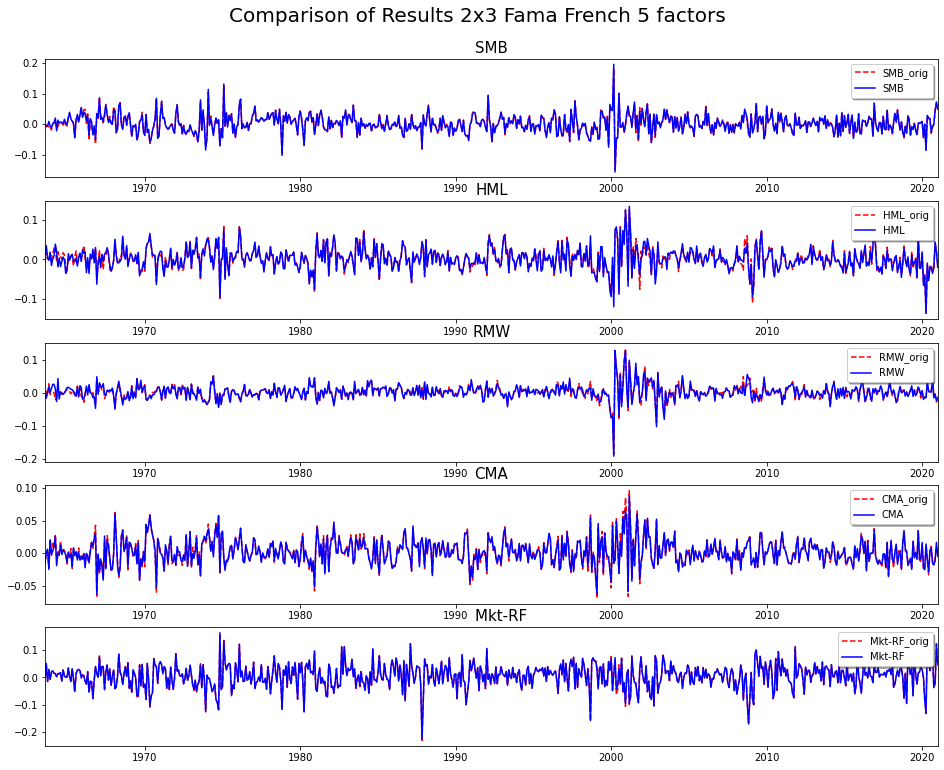

In [66]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results 2x3 Fama French 5 factors', fontsize=20)

ax1 = plt.subplot(511)
ax1.set_title('SMB', fontsize=15)
ax1.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
ax1.plot(ff_comp['SMB_orig'], 'r--', ff_comp['SMB'], 'b-')
ax1.legend(('SMB_orig','SMB'), loc='upper right', shadow=True)

ax2 = plt.subplot(512)
ax2.set_title('HML', fontsize=15)
ax2.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
ax2.plot(ff_comp['HML_orig'], 'r--', ff_comp['HML'], 'b-')
ax2.legend(('HML_orig','HML'), loc='upper right', shadow=True)

ax3 = plt.subplot(513)
ax3.set_title('RMW', fontsize=15)
ax3.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
ax3.plot(ff_comp['RMW_orig'], 'r--', ff_comp['RMW'], 'b-')
ax3.legend(('RMW_orig','RMW'), loc='upper right', shadow=True)

ax4 = plt.subplot(514)
ax4.set_title('CMA', fontsize=15)
ax4.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
ax4.plot(ff_comp['CMA_orig'], 'r--', ff_comp['CMA'], 'b-')
ax4.legend(('CMA_orig','CMA'), loc='upper right', shadow=True)

ax5 = plt.subplot(515)
ax5.set_title('    Mkt-RF', fontsize=15)
ax5.set_xlim([ff_comp.index.date.min(), ff_comp.index.date.max()])
ax5.plot(ff_comp['Mkt-RF_orig'], 'r--', ff_comp['Mkt-RF'], 'b-')
ax5.legend(('Mkt-RF_orig','Mkt-RF'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

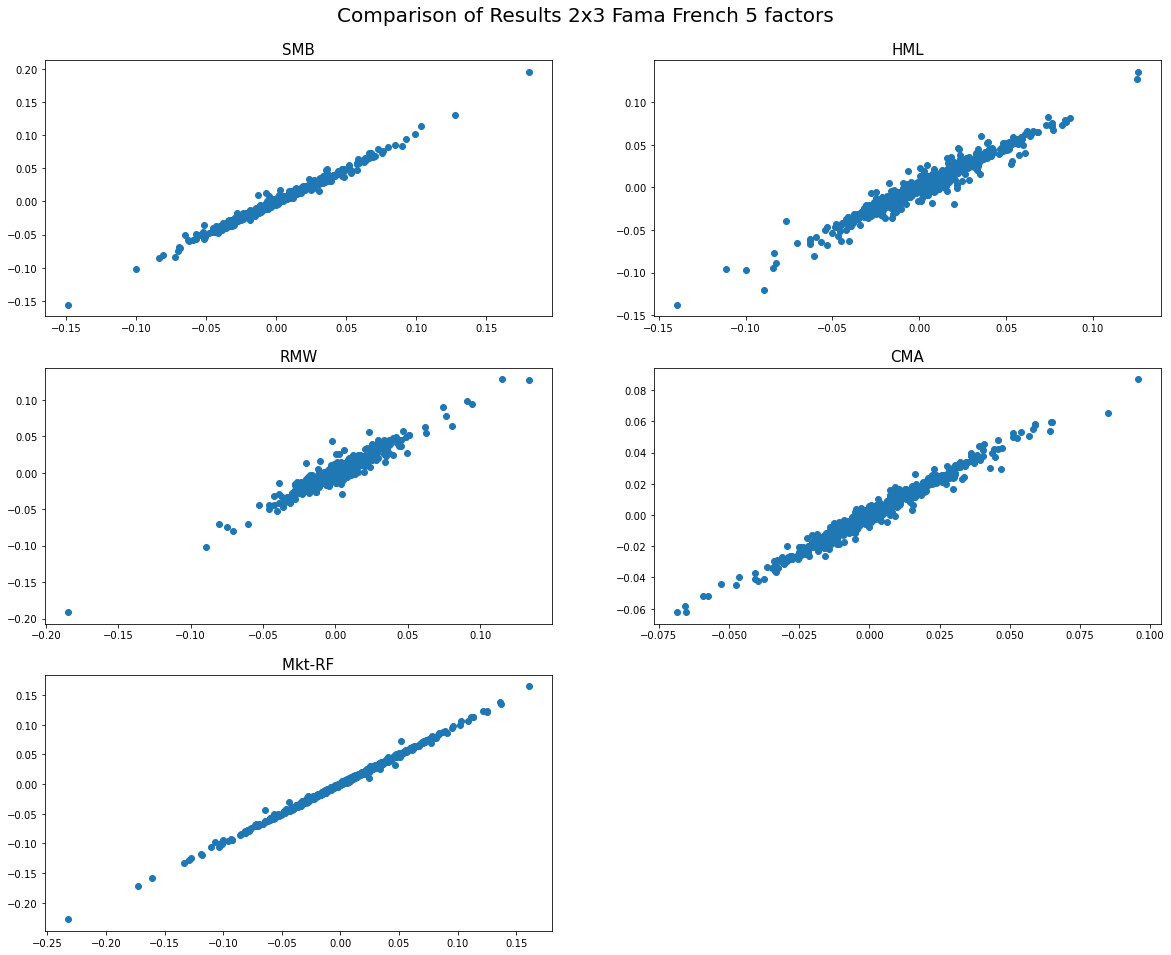

In [83]:
plt.figure(figsize=(20,25))
plt.suptitle('Comparison of Results 2x3 Fama French 5 factors', fontsize=20)

ax1 = plt.subplot(521)
ax1.set_title('SMB', fontsize=15)
plt.scatter(ff_comp['SMB_orig'], ff_comp['SMB'])

ax2 = plt.subplot(522)
ax2.set_title('HML', fontsize=15)
plt.scatter(ff_comp['HML_orig'], ff_comp['HML'])

ax3 = plt.subplot(523)
ax3.set_title('RMW', fontsize=15)
plt.scatter(ff_comp['RMW_orig'], ff_comp['RMW'])

ax4 = plt.subplot(524)
ax4.set_title('CMA', fontsize=15)
plt.scatter(ff_comp['CMA_orig'], ff_comp['CMA'])

ax5 = plt.subplot(525)
ax5.set_title('    Mkt-RF', fontsize=15)
plt.scatter(ff_comp['Mkt-RF_orig'], ff_comp['Mkt-RF'])  

plt.subplots_adjust(top=0.95, hspace=0.2)

plt.show()

Export the replicated factors

In [ ]:
ff_factors_final.to_csv('G:\\My Drive\\PhD\\Research\\Indipendent project\\estimated_data\\factors\\FF5_factors_replicated.csv', encoding='utf-8', index=True, header=True)